In [1]:
# -*- coding: utf-8 -*-

# 01-BU

"""

Describe the business objectives here

"""

# 02-DU

# Load Dataset

file = 'WA_Fn-UseC_-Telco-Customer-Churn.xlsx'

from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Create a Spark session
spark = SparkSession.builder \
    .appName("ExcelFileReader") \
    .config("spark.jars.packages", "com.crealytics:spark-excel_2.12:0.13.5") \
    .getOrCreate()
# Read the Excel file
df = spark.read \
    .format("com.crealytics.spark.excel") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(file)
df.show()
# Get the shape of the DataFrame
num_rows = df.count()
num_cols = len(df.columns)
print((num_rows, num_cols))
df.printSchema()
# Convert columns to numeric
df = df.withColumn("MonthlyCharges", col("MonthlyCharges").cast("double"))
df = df.withColumn("TotalCharges", col("TotalCharges").cast("double"))

:: loading settings :: url = jar:file:/home/ubuntu/.local/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/ubuntu/.ivy2/cache
The jars for the packages stored in: /home/ubuntu/.ivy2/jars
com.crealytics#spark-excel_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-0fca7bc5-4e9d-44ce-922b-5e904970a782;1.0
	confs: [default]
	found com.crealytics#spark-excel_2.12;0.13.5 in central
	found org.apache.poi#poi;4.1.2 in central
	found commons-codec#commons-codec;1.13 in central
	found org.apache.commons#commons-collections4;4.4 in central
	found org.apache.commons#commons-math3;3.6.1 in central
	found com.zaxxer#SparseBitSet;1.2 in central
	found org.apache.poi#poi-ooxml;4.1.2 in central
	found org.apache.poi#poi-ooxml-schemas;4.1.2 in central
	found org.apache.xmlbeans#xmlbeans;3.1.0 in central
	found com.github.virtuald#curvesapi;1.06 in central
	found com.norbitltd#spoiwo_2.12;1.7.0 in central
	found org.scala-lang.modules#scala-xml_2.12;1.2.0 in central
	found com.github.pjfanning#excel-streaming-reader;2.3.4 in central
	

+----------+------+-------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|ZipCode|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female| 4584.0|          

In [2]:
import pandas as pd
# Convert to pandas DataFrame for better display
pandas_df = df.toPandas()

# Display the pandas DataFrame
display(pandas_df)
pandas_df.info()

,customerID,gender,ZipCode,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,4584.0,0.0,Yes,No,1.0,No,No phone service,DSL,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,6485.0,0.0,No,No,34.0,Yes,No,DSL,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,5423.0,0.0,No,No,2.0,Yes,No,DSL,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,9023.0,0.0,No,No,45.0,No,No phone service,DSL,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,2490.0,0.0,No,No,2.0,Yes,No,Fiber optic,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,3549.0,0.0,Yes,Yes,24.0,Yes,Yes,DSL,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,2234-XADUH,Female,6260.0,0.0,Yes,Yes,72.0,Yes,Yes,Fiber optic,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,4801-JZAZL,Female,6333.0,0.0,Yes,Yes,11.0,No,No phone service,DSL,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,4739.0,1.0,Yes,No,4.0,Yes,Yes,Fiber optic,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   ZipCode           3618 non-null   float64
 3   SeniorCitizen     7043 non-null   float64
 4   Partner           7043 non-null   object 
 5   Dependents        7043 non-null   object 
 6   tenure            7043 non-null   float64
 7   PhoneService      7043 non-null   object 
 8   MultipleLines     7043 non-null   object 
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   object 
 11  OnlineBackup      7043 non-null   object 
 12  DeviceProtection  7041 non-null   object 
 13  TechSupport       7041 non-null   object 
 14  StreamingTV       7043 non-null   object 
 15  StreamingMovies   7043 non-null   object 
 16  Contract          7043 non-null   object 


+-------+---------------+
|summary|InternetService|
+-------+---------------+
|  count|           7043|
|   mean|           null|
| stddev|           null|
|    min|            DSL|
|    max|             No|
+-------+---------------+

[Row(InternetService='Fiber optic', count=3096), Row(InternetService='No', count=1526), Row(InternetService='DSL', count=2419), Row(InternetService='DSLdsf', count=1), Row(InternetService='DSLdsaf', count=1)]


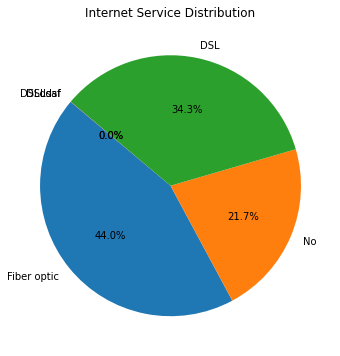

In [3]:
# Explore Data
import matplotlib.pyplot as plt

# Describe the 'InternetService' column
df.select("InternetService").describe().show()

# Get the value counts for 'InternetService'
internet_service_counts = df.groupBy("InternetService").count()
internet_service_counts_df = internet_service_counts.collect()
print(internet_service_counts_df)

# Extract data for plotting
internet_service_labels = [row['InternetService'] for row in internet_service_counts_df]
internet_service_values = [row['count'] for row in internet_service_counts_df]

# Plot the Internet Service Distribution
plt.figure(figsize=(8, 6))
plt.pie(internet_service_values, labels=internet_service_labels, autopct='%1.1f%%', startangle=140)
plt.title('Internet Service Distribution')
plt.show()

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


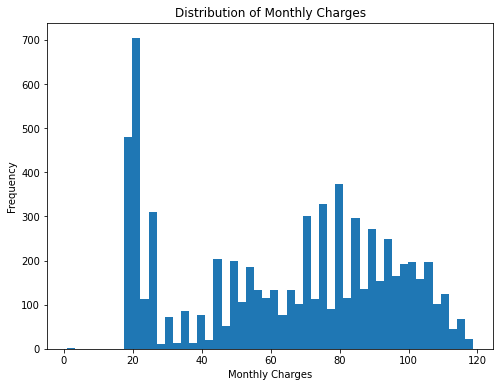

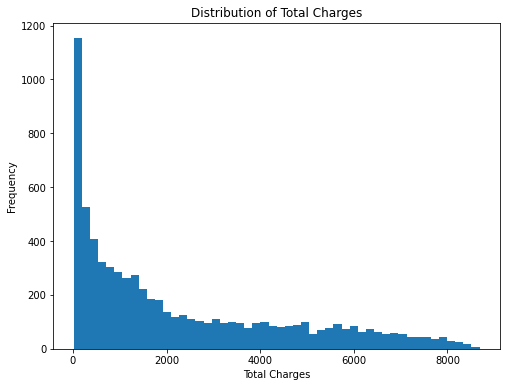

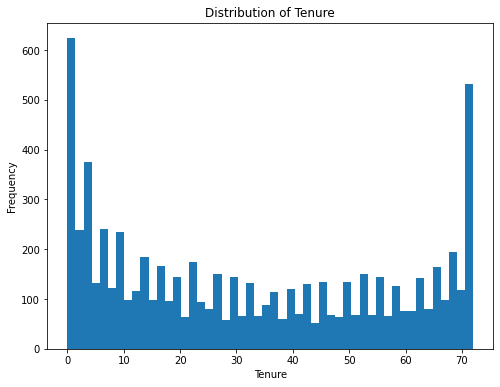

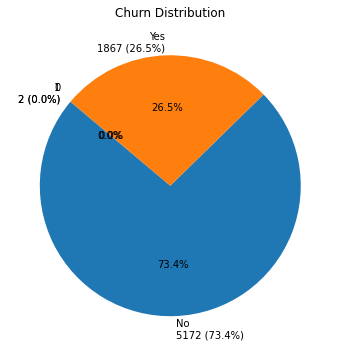

Null Counts:
+------------------+--------------+
| Column           |   Null Count |
+==================+==============+
| customerID       |            0 |
+------------------+--------------+
| gender           |            0 |
+------------------+--------------+
| ZipCode          |         3425 |
+------------------+--------------+
| SeniorCitizen    |            0 |
+------------------+--------------+
| Partner          |            0 |
+------------------+--------------+
| Dependents       |            0 |
+------------------+--------------+
| tenure           |            0 |
+------------------+--------------+
| PhoneService     |            0 |
+------------------+--------------+
| MultipleLines    |            0 |
+------------------+--------------+
| InternetService  |            0 |
+------------------+--------------+
| OnlineSecurity   |            0 |
+------------------+--------------+
| OnlineBackup     |            0 |
+------------------+--------------+
| DeviceProtect

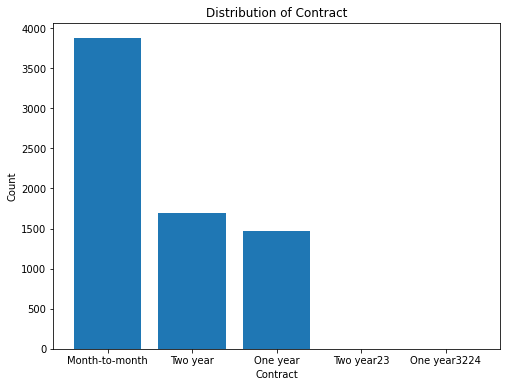

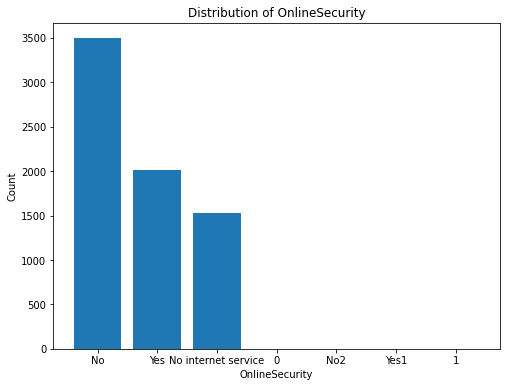

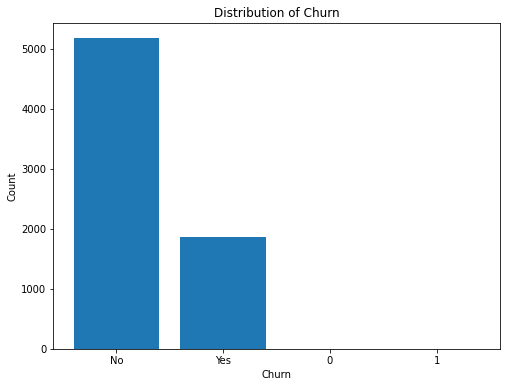

In [4]:
from pyspark.sql.functions import count, when
%pip install tabulate

from tabulate import tabulate

# Plot the distribution of Monthly Charges
monthly_charges = df.select("MonthlyCharges").dropna().rdd.flatMap(lambda x: x).collect()
plt.figure(figsize=(8, 6))
plt.hist(monthly_charges, bins=50)
plt.xlabel('Monthly Charges')
plt.ylabel('Frequency')
plt.title('Distribution of Monthly Charges')
plt.show()

# Plot the distribution of Total Charges
total_charges = df.select("TotalCharges").dropna().rdd.flatMap(lambda x: x).collect()
plt.figure(figsize=(8, 6))
plt.hist(total_charges, bins=50)
plt.xlabel('Total Charges')
plt.ylabel('Frequency')
plt.title('Distribution of Total Charges')
plt.show()

# Plot the distribution of Tenure
tenure = df.select("tenure").dropna().rdd.flatMap(lambda x: x).collect()
plt.figure(figsize=(8, 6))
plt.hist(tenure, bins=50)
plt.xlabel('Tenure')
plt.ylabel('Frequency')
plt.title('Distribution of Tenure')
plt.show()

# Plot the pie chart for Churn
churn_counts = df.groupBy("Churn").count().orderBy("count", ascending=False).collect()
labels = [row['Churn'] for row in churn_counts]
sizes = [row['count'] for row in churn_counts]
total = sum(sizes)
labels_with_counts = [f'{label}\n{count} ({count/total:.1%})' for label, count in zip(labels, sizes)]
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels_with_counts, autopct='%1.1f%%', startangle=140)
plt.title('Churn Distribution')
plt.show()

# Count null values in each column and display in a table
null_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).collect()
null_counts_dict = null_counts[0].asDict()
null_data = [[col, null_counts_dict[col]] for col in df.columns]
print("Null Counts:")
print(tabulate(null_data, headers=["Column", "Null Count"], tablefmt="grid"))



# Compute descriptive statistics for the selected columns
selected_columns = ["ZipCode", "SeniorCitizen", "tenure", "MonthlyCharges", "TotalCharges"]
df_selected = df.select(selected_columns)
desc_stats = df_selected.describe().collect()
desc_headers = desc_stats[0].asDict().keys()
desc_data = [row.asDict().values() for row in desc_stats]
print("Descriptive Statistics:")
print(tabulate(desc_data, headers=desc_headers, tablefmt="grid"))

# Plot bar charts for Contract, OnlineSecurity, and Churn
def plot_bar_chart(column_name):
    counts = df.groupBy(column_name).count().orderBy("count", ascending=False).collect()
    labels = [row[column_name] for row in counts]
    values = [row['count'] for row in counts]
    plt.figure(figsize=(8, 6))
    plt.bar(labels, values)
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.title(f'Distribution of {column_name}')
    plt.show()

plot_bar_chart("Contract")
plot_bar_chart("OnlineSecurity")
plot_bar_chart("Churn")

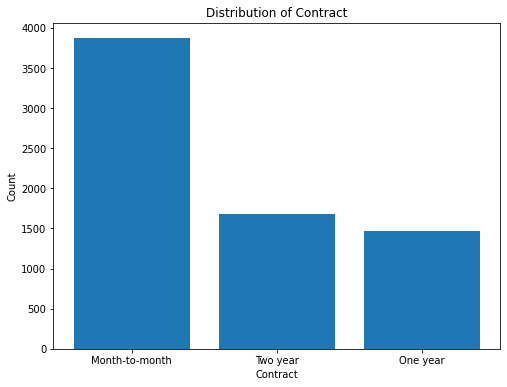

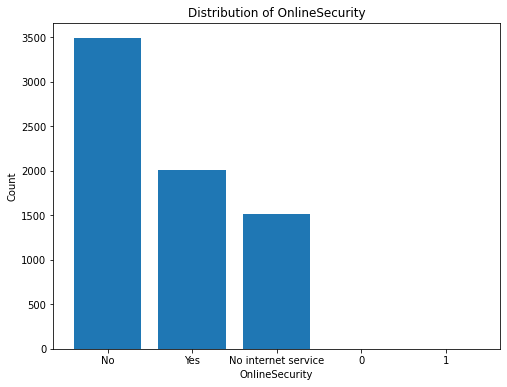

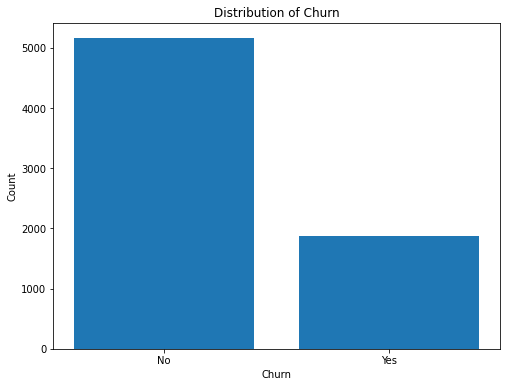

Null Counts:
+------------------+--------------+
| Column           |   Null Count |
+==================+==============+
| Dependents       |            0 |
+------------------+--------------+
| tenure           |            0 |
+------------------+--------------+
| PhoneService     |            0 |
+------------------+--------------+
| MultipleLines    |            0 |
+------------------+--------------+
| InternetService  |            0 |
+------------------+--------------+
| OnlineSecurity   |            0 |
+------------------+--------------+
| OnlineBackup     |            0 |
+------------------+--------------+
| DeviceProtection |            0 |
+------------------+--------------+
| TechSupport      |            0 |
+------------------+--------------+
| StreamingTV      |            0 |
+------------------+--------------+
| StreamingMovies  |            0 |
+------------------+--------------+
| Contract         |            0 |
+------------------+--------------+
| PaperlessBill

+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+-----------------+-----------+
|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Churn|TotalServicesUsed|TenureGroup|
+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+-----------------+-----------+
|         0|  34.0|           1|            0|              0|             1|           0|               1|          0|          0|              0|       1|               0|            2|         56.95|      1889.5|    0|                2|     

,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalServicesUsed,TenureGroup
0,0,34.0,1,0,0,1,0,1,0,0,0,1,0.0,2,56.95,1889.50,0,2,2
1,0,2.0,1,0,0,1,1,0,0,0,0,0,1.0,2,53.85,108.15,1,2,0
2,0,45.0,0,0,0,1,0,1,1,0,0,1,0.0,3,42.30,1840.75,0,3,3
3,0,2.0,1,0,0,0,0,0,0,0,0,0,1.0,1,70.70,151.65,1,0,0
4,0,8.0,1,1,0,0,0,1,0,1,1,0,1.0,1,99.65,820.50,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5927,0,72.0,1,0,0,0,0,0,0,0,0,2,1.0,3,21.15,1419.40,0,0,5
5928,1,24.0,1,1,0,1,0,1,1,1,1,1,1.0,2,84.80,1990.50,0,5,1
5929,1,11.0,0,0,0,1,0,0,0,0,0,0,1.0,1,29.60,346.45,0,1,0
5930,0,4.0,1,1,0,0,0,0,0,0,0,0,1.0,2,74.40,306.60,1,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5932 entries, 0 to 5931
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Dependents         5932 non-null   int32  
 1   tenure             5932 non-null   float64
 2   PhoneService       5932 non-null   int32  
 3   MultipleLines      5932 non-null   int32  
 4   InternetService    5932 non-null   int32  
 5   OnlineSecurity     5932 non-null   int32  
 6   OnlineBackup       5932 non-null   int32  
 7   DeviceProtection   5932 non-null   int32  
 8   TechSupport        5932 non-null   int32  
 9   StreamingTV        5932 non-null   int32  
 10  StreamingMovies    5932 non-null   int32  
 11  Contract           5932 non-null   int32  
 12  PaperlessBilling   5928 non-null   float64
 13  PaymentMethod      5932 non-null   int32  
 14  MonthlyCharges     5932 non-null   float64
 15  TotalCharges       5932 non-null   float64
 16  Churn              5932 

In [5]:
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType

# Dropping specific columns
columns_to_drop = ['ZipCode', 'customerID', 'gender', 'SeniorCitizen', 'Partner']
df_cleaned = df.drop(*columns_to_drop)

# Define a function to check if a value is blank or null
def is_blank_or_null(column):
    return (col(column).isNull()) | (col(column) == "") | (col(column).rlike(r'^\s*$'))

# Filter the dataset based on the given conditions
df_cleaned = df_cleaned.filter(
    ~is_blank_or_null('DeviceProtection') &
    ~is_blank_or_null('TechSupport') &
    ~col('TotalCharges').isNull() &
    ~col('MonthlyCharges').isNull()
)

# Correcting inconsistencies in relevant columns
df_cleaned = df_cleaned.withColumn('Churn', when(col('Churn') == 1, 'Yes').otherwise(when(col('Churn') == 0, 'No').otherwise(col('Churn'))))
df_cleaned = df_cleaned.withColumn('OnlineSecurity', when(col('OnlineSecurity') == 'Yes1', 'Yes').when(col('OnlineSecurity') == 'No2', 'No').otherwise(col('OnlineSecurity')))
df_cleaned = df_cleaned.withColumn('PaymentMethod', when(col('PaymentMethod') == 'Electronic check111', 'Electronic check')
                                    .when(col('PaymentMethod') == 'Bank transfer (automatic)222', 'Bank transfer (automatic)').otherwise(col('PaymentMethod')))
df_cleaned = df_cleaned.withColumn('Contract', when(col('Contract') == 'One year3224', 'One year').when(col('Contract') == 'Two year23', 'Two year').otherwise(col('Contract')))


# Plot bar charts for Contract, OnlineSecurity, and Churn
def plot_bar_chart(df_cleaned, column):
    counts = df_cleaned.groupBy(column).count().orderBy("count", ascending=False).collect()
    labels = [row[column] for row in counts]
    values = [row['count'] for row in counts]
    plt.figure(figsize=(8, 6))
    plt.bar(labels, values)
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.title(f'Distribution of {column}')
    plt.show()

plot_bar_chart(df_cleaned, 'Contract')
plot_bar_chart(df_cleaned, 'OnlineSecurity')
plot_bar_chart(df_cleaned, 'Churn')

# Count null values in each column and display in a table
null_counts = df_cleaned.select([count(when(col(c).isNull(), c)).alias(c) for c in df_cleaned.columns]).collect()
null_counts_dict = null_counts[0].asDict()
null_data = [[col, null_counts_dict[col]] for col in df_cleaned.columns]
print("Null Counts:")
print(tabulate(null_data, headers=["Column", "Null Count"], tablefmt="grid"))

# Determine the 10th and 90th percentile thresholds for `MonthlyCharges` and `TotalCharges`
monthly_charges_lower = df_cleaned.approxQuantile("MonthlyCharges", [0.05], 0.0)[0]
monthly_charges_upper = df_cleaned.approxQuantile("MonthlyCharges", [0.95], 0.0)[0]
total_charges_lower = df_cleaned.approxQuantile("TotalCharges", [0.05], 0.0)[0]
total_charges_upper = df_cleaned.approxQuantile("TotalCharges", [0.95], 0.0)[0]

# Filtering out rows outside these thresholds
df_cleaned = df_cleaned.filter(
    (col('MonthlyCharges') >= monthly_charges_lower) & (col('MonthlyCharges') <= monthly_charges_upper) &
    (col('TotalCharges') >= total_charges_lower) & (col('TotalCharges') <= total_charges_upper)
)

# Define columns representing individual services
service_columns = [
    'InternetService', 'StreamingTV', 'StreamingMovies', 
    'TechSupport', 'DeviceProtection', 'OnlineBackup', 'OnlineSecurity'
]

# Converting these columns to binary indicators (1 if 'Yes', 0 if 'No')
for col_name in service_columns:
    df_cleaned = df_cleaned.withColumn(col_name, when(col(col_name) == 'Yes', 1).otherwise(0))

# Create a new feature for total services used
df_cleaned = df_cleaned.withColumn('TotalServicesUsed', sum([col(c) for c in service_columns]))

# Define a function to group tenure
def tenure_group(tenure):
    if tenure <= 12:
        return 0
    elif tenure <= 24:
        return 1
    elif tenure <= 36:
        return 2
    elif tenure <= 48:
        return 3
    elif tenure <= 60:
        return 4
    else:
        return 5

# Apply the function to create a new column for tenure grouping
tenure_group_udf = F.udf(tenure_group, IntegerType())
df_cleaned = df_cleaned.withColumn('TenureGroup', tenure_group_udf(col('tenure')))

# Load the split datasets from Excel files
data_part1 = spark.read \
    .format("com.crealytics.spark.excel") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('WA_Fn-UseC_-Telco-Customer-Churn-dirty.xlsx')

data_part2 = spark.read \
    .format("com.crealytics.spark.excel") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('WA_Fn-UseC_-Telco-Customer-Churn-dirty2.xlsx')


data_part1 = data_part1.withColumn("row_id", F.monotonically_increasing_id())
data_part2 = data_part2.withColumn("row_id", F.monotonically_increasing_id())
# Join the DataFrames on the row index
merged_data = data_part1.join(data_part2, on="row_id", how="inner").drop("row_id")
data_part1.drop("row_id")
data_part2.drop("row_id")

# Show the number of rows and columns for each DataFrame
print("data_part1: Rows = {}, Columns = {}".format(data_part1.count(), len(data_part1.columns)))
print("data_part2: Rows = {}, Columns = {}".format(data_part2.count(), len(data_part2.columns)))
print("merged_data: Rows = {}, Columns = {}".format(merged_data.count(), len(merged_data.columns)))

# Define label mapping for categorical columns
label_mapping = {
    'No': 0,
    'Yes': 1,
    'No internet service': 0,
    'DSL': 1,
    'Fiber optic': 2,
    'Electronic check': 1,
    'Mailed check': 2,
    'Bank transfer (automatic)': 3,
    'Credit card (automatic)': 4,
    'Month-to-month': 0,
    'One year': 1,
    'Two year': 2,
    'No phone service': 0  # Added mapping for MultipleLines
}

# Function to map categorical values to numerical labels
def safe_map(value, mapping):
    return mapping.get(value, value)

safe_map_udf = F.udf(lambda x: safe_map(x, label_mapping), IntegerType())

# Apply safe_map to relevant columns and cast to IntegerType
df_cleaned = df_cleaned.withColumn('Churn', safe_map_udf(col('Churn')).cast(IntegerType()))
df_cleaned = df_cleaned.withColumn('PaymentMethod', safe_map_udf(col('PaymentMethod')).cast(IntegerType()))
df_cleaned = df_cleaned.withColumn('Dependents', safe_map_udf(col('Dependents')).cast(IntegerType()))
df_cleaned = df_cleaned.withColumn('PhoneService', safe_map_udf(col('PhoneService')).cast(IntegerType()))
df_cleaned = df_cleaned.withColumn('MultipleLines', safe_map_udf(col('MultipleLines')).cast(IntegerType()))
df_cleaned = df_cleaned.withColumn('Contract', safe_map_udf(col('Contract')).cast(IntegerType()))
df_cleaned = df_cleaned.withColumn('PaperlessBilling', safe_map_udf(col('PaperlessBilling')).cast(IntegerType()))

# Show the cleaned DataFrame
df_cleaned.show()

# Convert to pandas DataFrame for better display
pandas_df_cleaned = df_cleaned.toPandas()

# Display the pandas DataFrame
display(pandas_df_cleaned)
pandas_df_cleaned.info()

/home/ubuntu/.local/lib/python3.10/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Chi-square test results for categorical features:
Feature: PaymentMethod, P-value: 0.0000
Feature: TenureGroup, P-value: 0.0000
Feature: StreamingTV, P-value: 0.0000
Feature: StreamingMovies, P-value: 0.0000
Feature: TechSupport, P-value: 0.0000
Feature: DeviceProtection, P-value: 0.0692
Feature: OnlineBackup, P-value: 0.0014
Feature: OnlineSecurity, P-value: 0.0000
Feature: Dependents, P-value: 0.0000
Feature: PhoneService, P-value: 0.0000
Feature: MultipleLines, P-value: 0.0000
Feature: Contract, P-value: 0.0000
Feature: PaperlessBilling, P-value: 0.0000
Correlation matrix:
                      tenure  MonthlyCharges  TotalCharges  TotalServicesUsed  \
tenure             1.000000        0.054642      0.814761           0.393645   
MonthlyCharges     0.054642        1.000000      0.528828           0.620177   
TotalCharges       0.814761        0.528828      1.000000           0.660283   
TotalServicesUsed  0.393645        0.620177      0.660283           1.000000   
Churn           

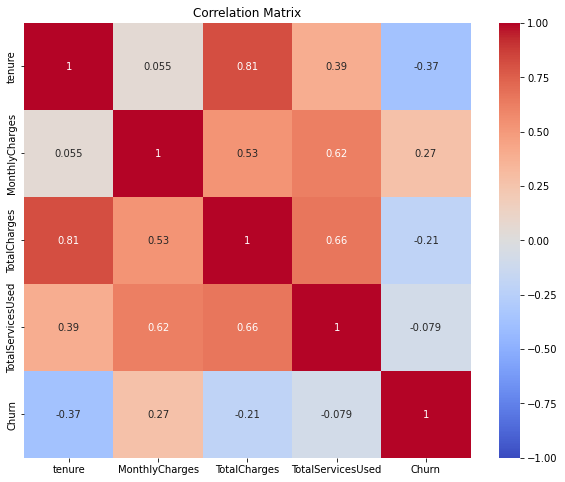

In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, log1p
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.stat import ChiSquareTest
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
import pandas as pd
import numpy as np

# Selecting all relevant columns
categorical_features = ['InternetService', 'PaymentMethod', 'TenureGroup', 'StreamingTV', 
                        'StreamingMovies', 'TechSupport', 'DeviceProtection', 'OnlineBackup', 
                        'OnlineSecurity', 'Dependents', 'PhoneService', 'MultipleLines', 
                        'Contract', 'PaperlessBilling']
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'TotalServicesUsed']

# Identify columns with at least two distinct values
valid_categorical_features = [col for col in categorical_features if df_cleaned.select(col).distinct().count() > 1]

# One-hot encoding for categorical features with handleInvalid='skip'
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index", handleInvalid='skip').fit(df_cleaned) for column in valid_categorical_features]
encoders = [OneHotEncoder(inputCol=column+"_index", outputCol=column+"_ohe") for column in valid_categorical_features]

# Assemble feature vectors
assembler = VectorAssembler(inputCols=[column+"_ohe" for column in valid_categorical_features] + numeric_features, outputCol="features")

# Pipeline for transformations
pipeline = Pipeline(stages=indexers + encoders + [assembler])
df_transformed = pipeline.fit(df_cleaned).transform(df_cleaned)

# Chi-square test for categorical features
chi_square_results = ChiSquareTest.test(df_transformed, "features", "Churn").head()
print("Chi-square test results for categorical features:")
for feature, p_val in zip(valid_categorical_features, chi_square_results.pValues):
    print(f"Feature: {feature}, P-value: {p_val:.4f}")

# Correlation matrix for numeric features
numeric_data = df_cleaned.select(numeric_features + ['Churn']).toPandas()
corr_matrix = numeric_data.corr()

# Display correlation matrix
print("Correlation matrix:\n", corr_matrix)

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()




In [7]:
%pip install scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
# Define the features and target
X = pandas_df_cleaned.drop(columns=['Churn'])
Y = pandas_df_cleaned['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Feature importances
feature_importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Display feature importances
print("Feature Importances:\n", feature_importances)

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Feature Importances:
 MonthlyCharges       0.217019
TotalCharges         0.184559
tenure               0.158415
Contract             0.078844
PaymentMethod        0.065526
TenureGroup          0.057146
TotalServicesUsed    0.042139
PaperlessBilling     0.026518
MultipleLines        0.022372
OnlineSecurity       0.021653
TechSupport          0.021621
Dependents           0.021592
OnlineBackup         0.020333
DeviceProtection     0.019031
StreamingTV          0.018221
StreamingMovies      0.017434
PhoneService         0.007576
InternetService      0.000000
dtype: float64


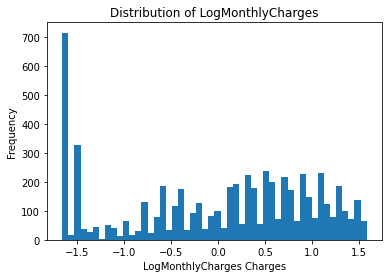

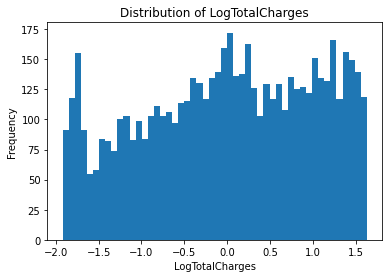

In [8]:
# Drop less important columns
columns_to_drop = ['Dependents', 'TotalServicesUsed','PhoneService', 'InternetService']
df_cleaned = df_cleaned.drop(*columns_to_drop)

# Log transformation for skewed features
df_cleaned = df_cleaned.withColumn('LogTotalCharges', log1p(col('TotalCharges')))
df_cleaned = df_cleaned.withColumn('LogMonthlyCharges', log1p(col('MonthlyCharges')))

# Standardize numeric features
assembler = VectorAssembler(inputCols=['LogTotalCharges', 'LogMonthlyCharges'], outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
pipeline = Pipeline(stages=[assembler, scaler])
df_scaled = pipeline.fit(df_cleaned).transform(df_cleaned)

# Convert to pandas DataFrame for plotting
pandas_df_cleaned = df_cleaned.select('LogTotalCharges', 'LogMonthlyCharges').toPandas()

# Applying Box-Cox transformation
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='box-cox')
pandas_df_cleaned[['LogTotalCharges', 'LogMonthlyCharges']] = pt.fit_transform(pandas_df_cleaned[['LogTotalCharges', 'LogMonthlyCharges']])

# Plot histograms
pandas_df_cleaned['LogMonthlyCharges'].plot.hist(bins=50)
plt.xlabel('LogMonthlyCharges Charges')
plt.ylabel('Frequency')
plt.title('Distribution of LogMonthlyCharges')
plt.show()

pandas_df_cleaned['LogTotalCharges'].plot.hist(bins=50)
plt.xlabel('LogTotalCharges')
plt.ylabel('Frequency')
plt.title('Distribution of LogTotalCharges')
plt.show()


In [21]:
%pip install xgboost
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score


# Assuming df_cleaned is already defined and columns have been dropped
# Prepare features for modeling
numeric_features = df_cleaned.columns
numeric_features = [col for col in numeric_features if col != 'Churn']

# Fill null values
df_cleaned = df_cleaned.fillna(0)

# Assemble feature vectors
assembler = VectorAssembler(inputCols=numeric_features, outputCol="features", handleInvalid="skip")

# Pipeline for transformations
pipeline = Pipeline(stages=[assembler])
df_transformed = pipeline.fit(df_cleaned).transform(df_cleaned)

# Convert features to numpy array for sklearn models
X = np.array(df_transformed.select("features").collect()).reshape(-1, len(numeric_features))
y = np.array(df_transformed.select("Churn").collect()).ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Evaluate Different Splits
splits = [(0.7, 0.3), (0.8, 0.2), (0.9, 0.1)]

rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
for train_size, test_size in splits:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Train model
    rf_model = rf.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = rf.predict(X_test)
    
    print(f"Split: {int(train_size * 100)}/{int(test_size * 100)}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_pred))
    print()

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Split: 70/30
Accuracy: 0.8016853932584269
F1 Score: 0.5919075144508671
ROC-AUC: 0.7145688433720888

Split: 80/20
Accuracy: 0.797809604043808
F1 Score: 0.5804195804195804
ROC-AUC: 0.7058957249174641

Split: 90/10
Accuracy: 0.8013468013468014
F1 Score: 0.6143790849673203
ROC-AUC: 0.724418683941357



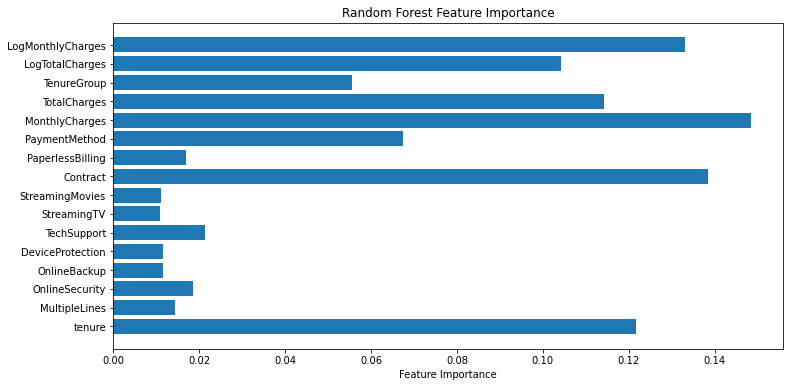

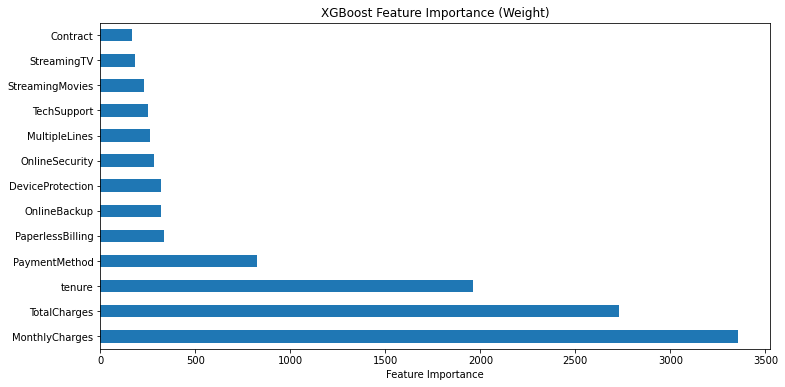

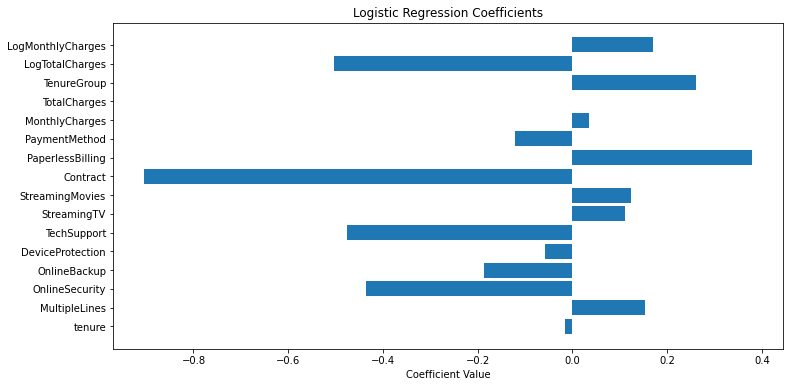

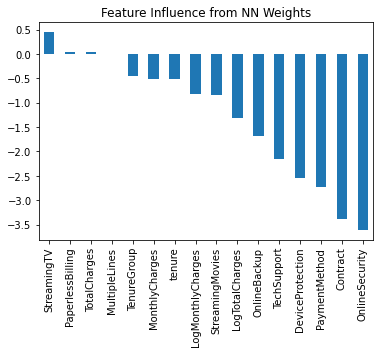

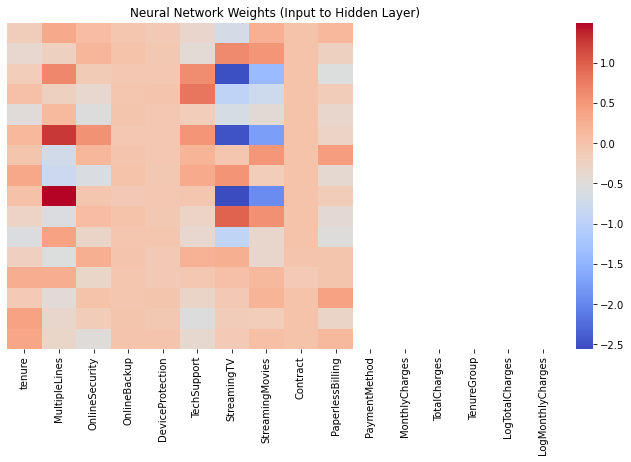

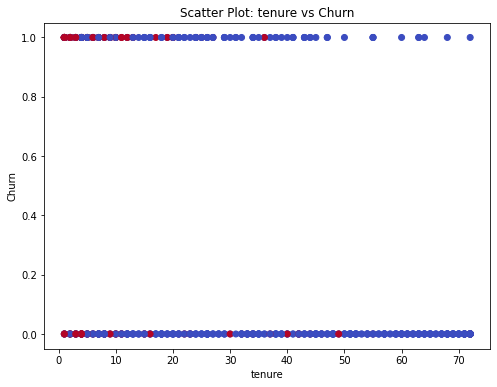

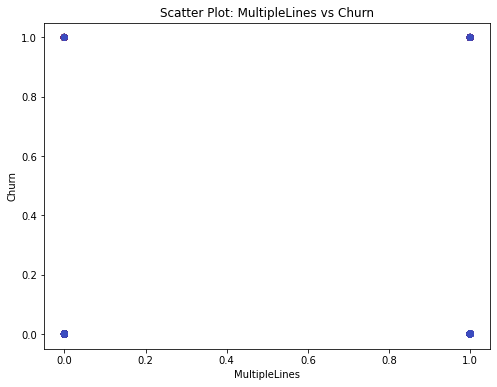

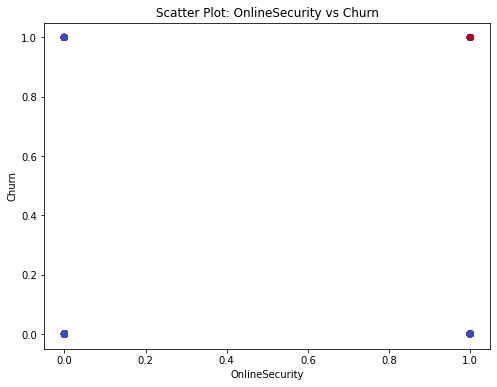

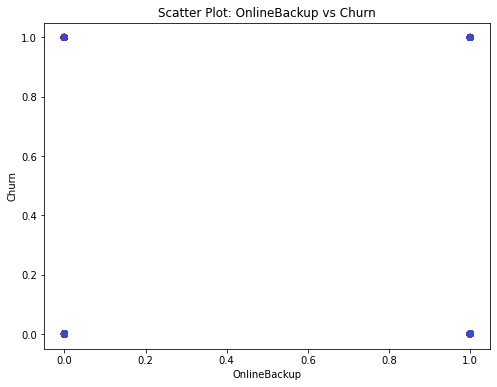

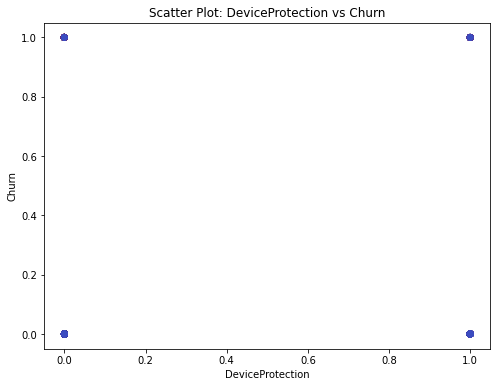

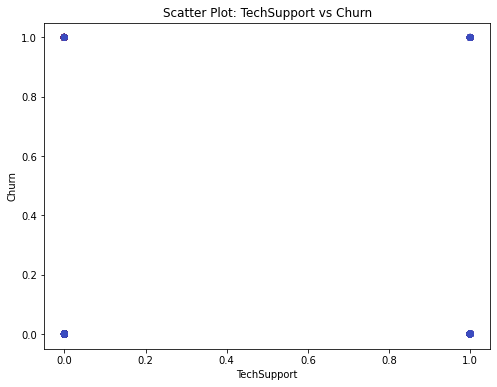

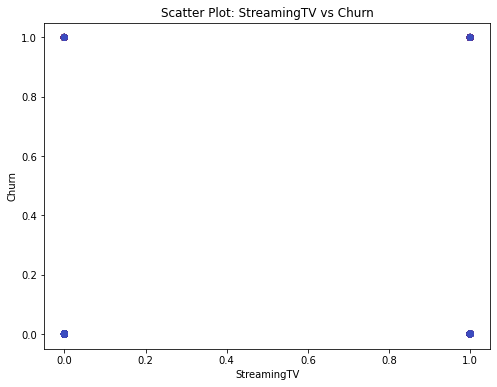

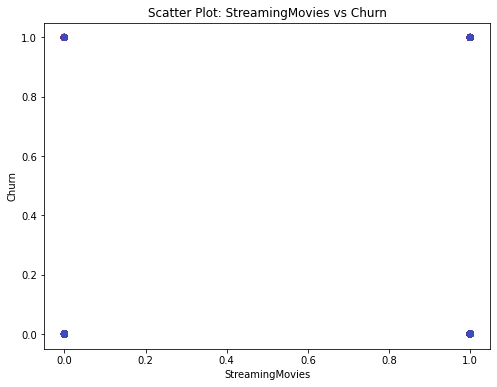

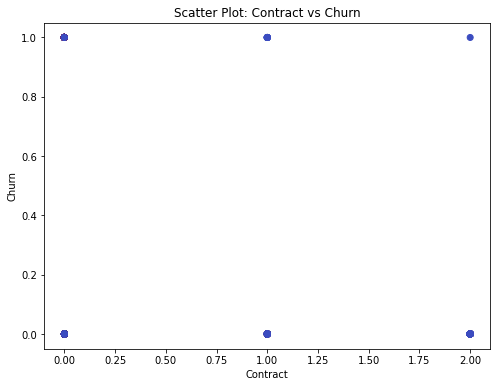

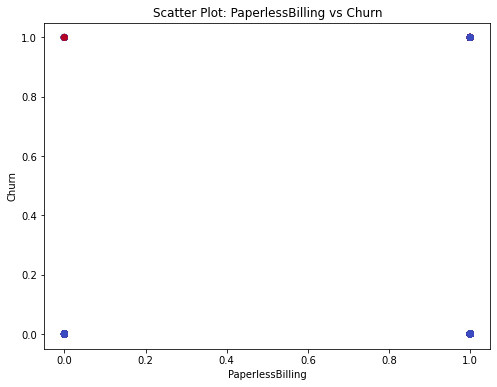

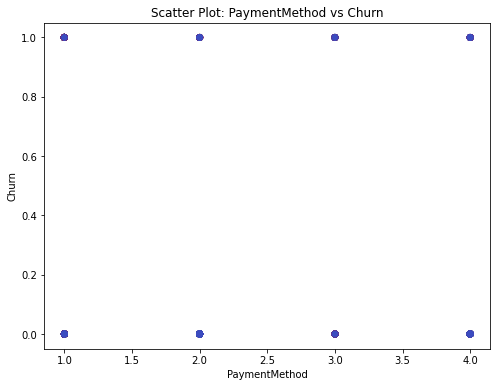

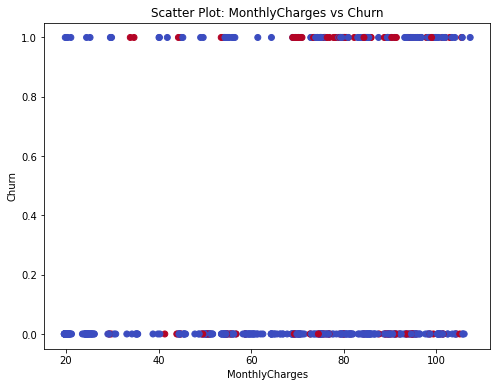

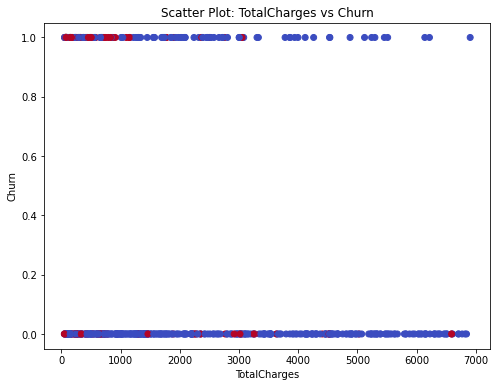

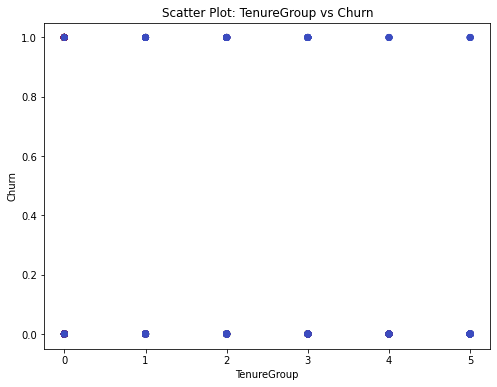

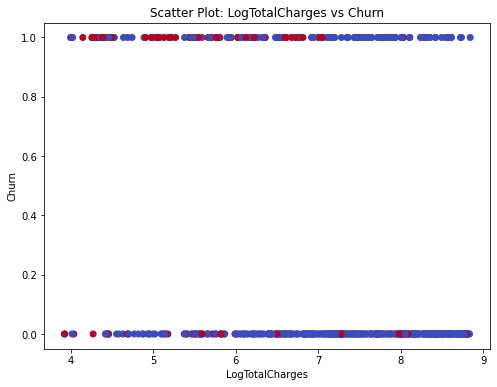

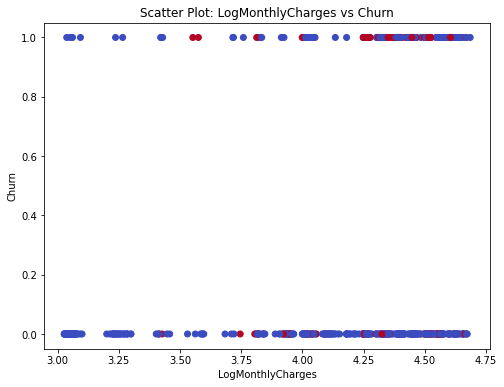

Evaluating Random Forest Model:
Accuracy: 0.7954
Precision: 0.6608
Recall: 0.5208
F1 Score: 0.5823

Evaluating Logistic Regression Model:
Accuracy: 0.8025
Precision: 0.6727
Recall: 0.5448
F1 Score: 0.6020

Evaluating Neural Networks Model:
Accuracy: 0.7819
Precision: 0.7216
Recall: 0.3608
F1 Score: 0.4645

Evaluating XGBoost Model:
Accuracy: 0.7827
Precision: 0.6214
Recall: 0.5284
F1 Score: 0.5708

Evaluating KNN Model:
Accuracy: 0.7670
Precision: 0.5967
Recall: 0.4628
F1 Score: 0.5211



In [36]:
# Train Random Forest model
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model = rf.fit(X_train, y_train)
# Feature Importance
importances = rf_model.feature_importances_
feature_names = numeric_features

# Visualize Feature Importance
plt.figure(figsize=(12, 6))
plt.barh(range(len(importances)), importances, align='center')
plt.yticks(range(len(importances)), feature_names)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()

# XGBoost model
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=10, random_state=42)
xgb_model.fit(X_train, y_train)
# Feature Importance
importances = xgb_model.get_booster().get_score(importance_type='weight')
# Map feature indices to feature names
feature_map = {f'f{i}': feature for i, feature in enumerate(numeric_features)}
# Convert the feature importance dictionary to a pandas Series
importances_series = pd.Series(importances).rename(index=feature_map).sort_values(ascending=False)
# Visualize the feature importance
plt.figure(figsize=(12, 6))
importances_series.plot(kind='barh', title="XGBoost Feature Importance (Weight)")
plt.xlabel("Feature Importance")
plt.show()

# Logistic Regression model
log_reg = LogisticRegression(max_iter=500, solver='liblinear', C=1.0, penalty='l2', random_state=42)
log_reg.fit(X_train, y_train)
# Coefficients
coefficients = log_reg.coef_[0]
# Visualize Coefficients
plt.figure(figsize=(12, 6))
plt.barh(range(len(coefficients)), coefficients, align='center')
plt.yticks(range(len(coefficients)), feature_names)
plt.xlabel("Coefficient Value")
plt.title("Logistic Regression Coefficients")
plt.show()

# Neural Network model
nn = MLPClassifier(hidden_layer_sizes=(10, 10), activation='relu', 
                   learning_rate_init=0.01, max_iter=200, random_state=42)
nn.fit(X_train, y_train)
# Extract weights from the model
input_to_hidden_weights = nn.coefs_[0]  # Weights from input to first hidden layer
# Visualize the weights
feature_influence = pd.DataFrame(input_to_hidden_weights, index=numeric_features)
feature_influence.sum(axis=1).sort_values(ascending=False).plot(kind='bar', title="Feature Influence from NN Weights")
plt.show()
# Visualize the weights
plt.figure(figsize=(12, 6))
sns.heatmap(input_to_hidden_weights, cmap='coolwarm', xticklabels=feature_names, yticklabels=False)
plt.title("Neural Network Weights (Input to Hidden Layer)")
plt.show()

# KNN Model
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train, y_train)
# Predict Churn
y_pred = knn.predict(X_test)
# Scatter Plot for Continuous Features
df_test = pd.DataFrame(X_test, columns=feature_names)
df_test['Churn'] = y_test
for feature in numeric_features:
    plt.figure(figsize=(8, 6))
    plt.scatter(df_test[feature], df_test['Churn'], c=y_pred, cmap='coolwarm')
    plt.xlabel(feature)
    plt.ylabel('Churn')
    plt.title(f"Scatter Plot: {feature} vs Churn")
    plt.show()

# StratifiedKFold for balanced splits
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Models
models = {
    "Random Forest": rf_model,
    "Logistic Regression": log_reg,
    "Neural Networks": nn,
    "XGBoost": xgb_model,
    "KNN": knn
}

# Evaluating models
for name, model in models.items():
    print(f"Evaluating {name} Model:")

    # Cross-validation scores
    acc_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    prec_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='precision')
    rec_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='recall')
    f1_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    
    print(f"Accuracy: {np.mean(acc_scores):.4f}")
    print(f"Precision: {np.mean(prec_scores):.4f}")
    print(f"Recall: {np.mean(rec_scores):.4f}")
    print(f"F1 Score: {np.mean(f1_scores):.4f}")
    print()

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


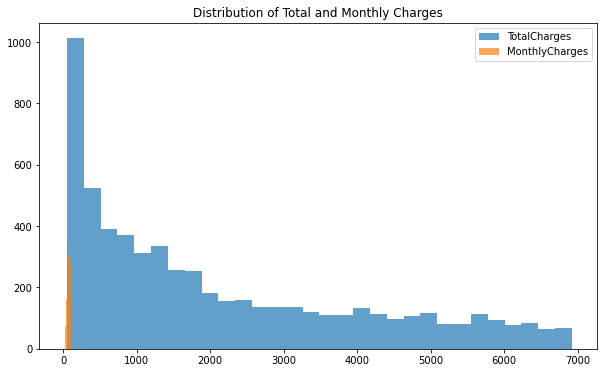

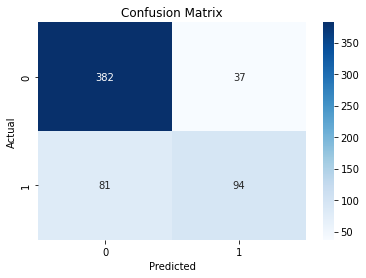

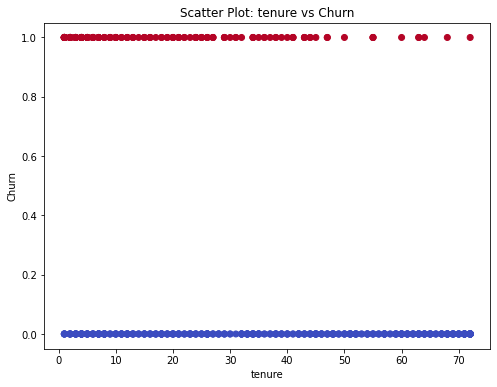

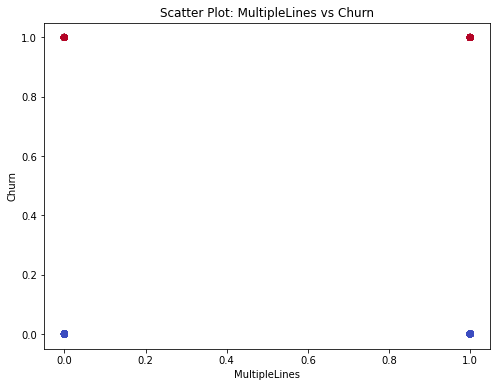

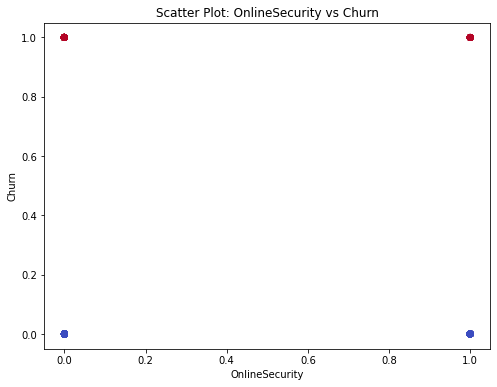

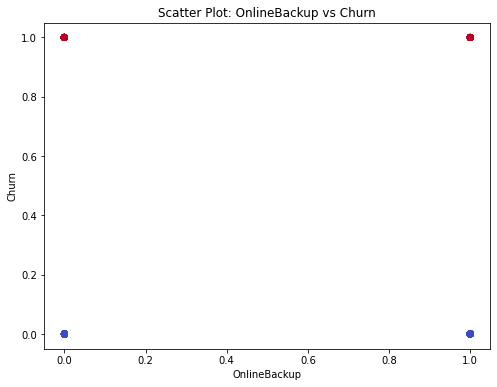

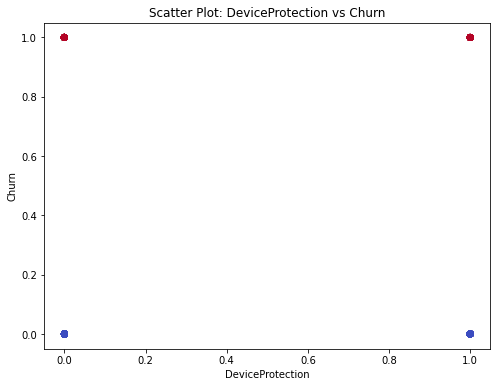

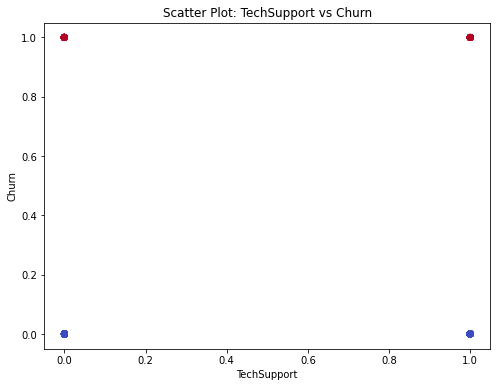

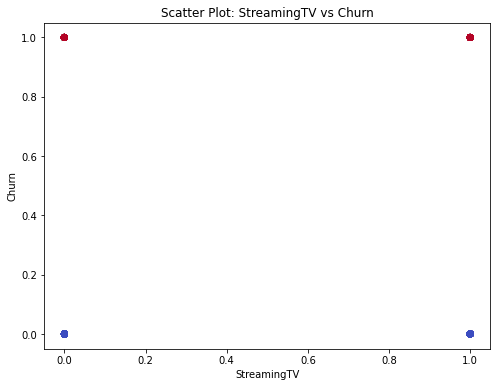

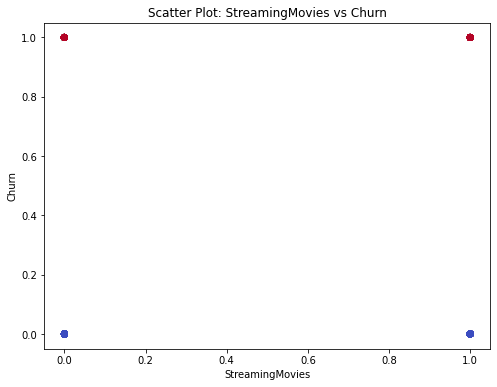

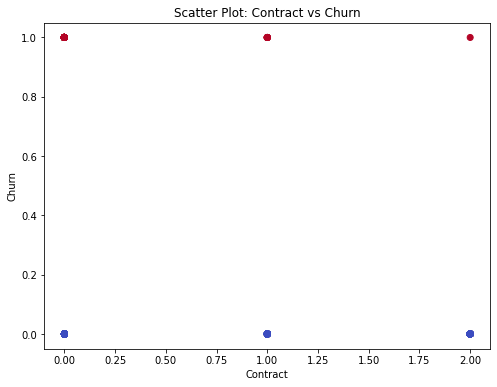

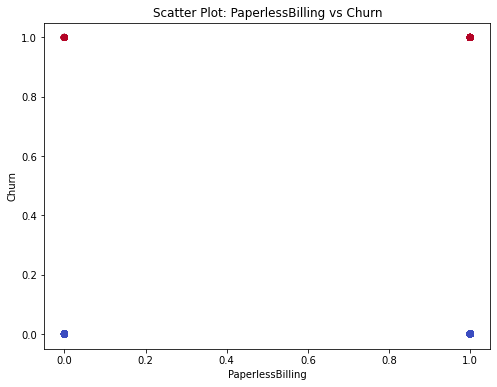

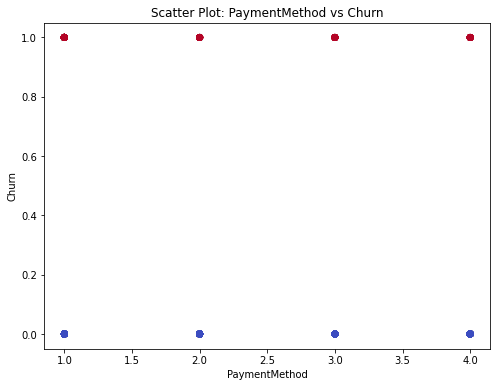

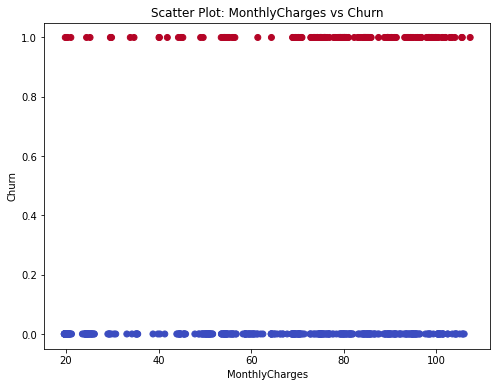

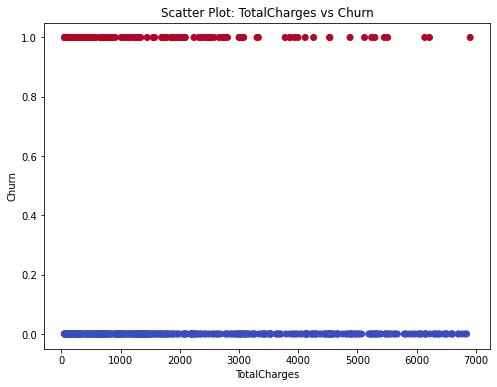

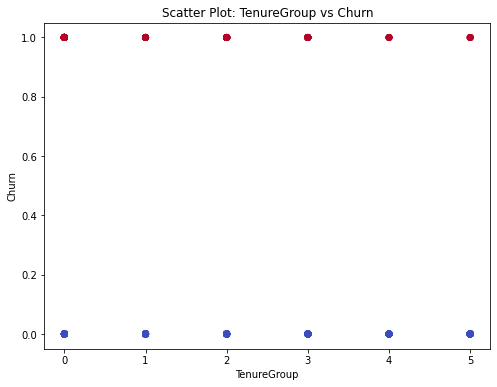

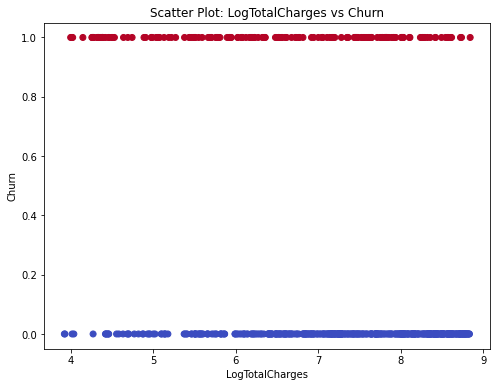

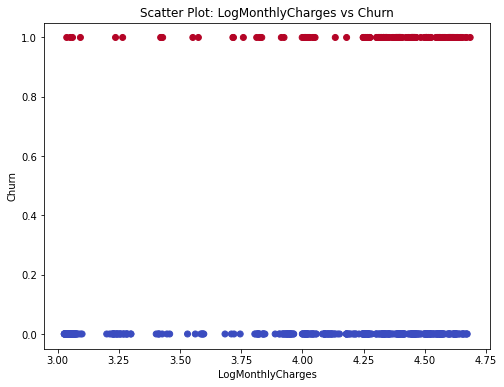

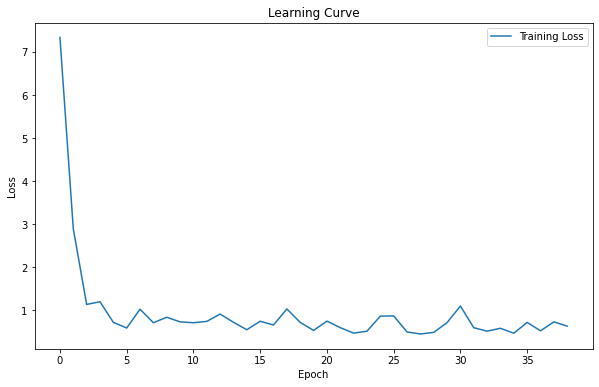

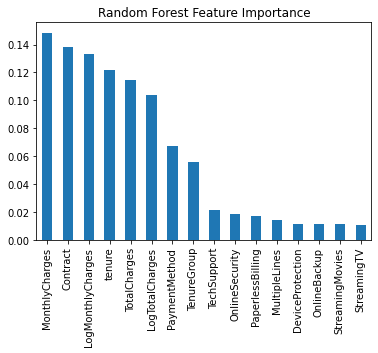

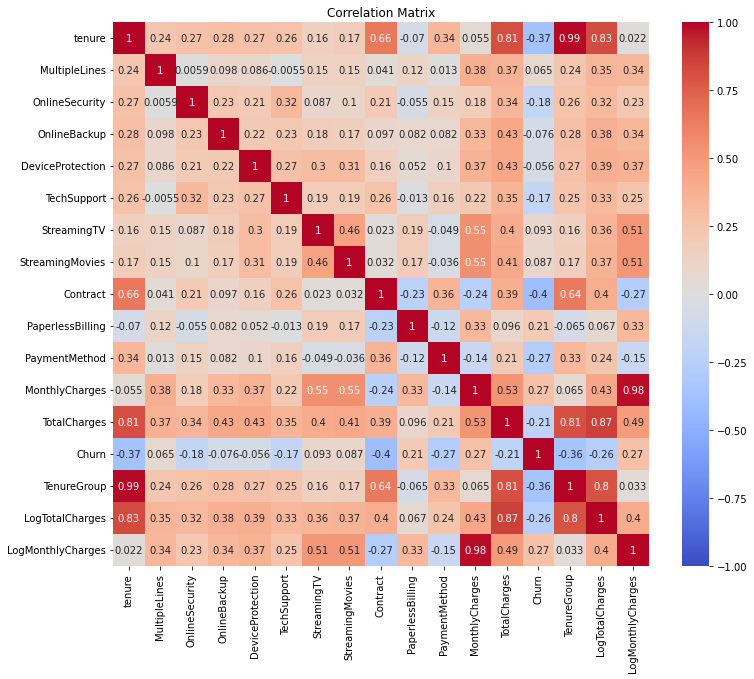

<Figure size 720x432 with 0 Axes>

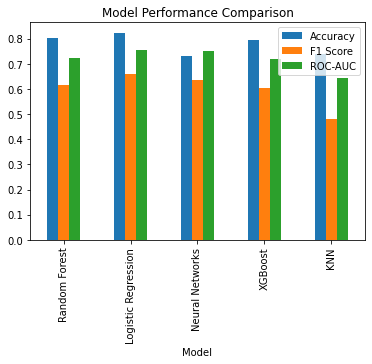

In [38]:
# 08-INT

# Summarize Results
# Add relevant tables or graphs
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score
%pip install shap
import shap

# Histograms
plt.figure(figsize=(10, 6))
plt.hist(df_cleaned.select('TotalCharges').toPandas(), bins=30, alpha=0.7, label='TotalCharges')
plt.hist(df_cleaned.select('MonthlyCharges').toPandas(), bins=30, alpha=0.7, label='MonthlyCharges')
plt.legend()
plt.title("Distribution of Total and Monthly Charges")
plt.show()

# Confusion Matrix
# Evaluation
y_pred = rf_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Scatter Plot for Continuous Features
df_test = pd.DataFrame(X_test, columns=numeric_features)
df_test['Churn'] = y_test

for feature in numeric_features:
    plt.figure(figsize=(8, 6))
    plt.scatter(df_test[feature], df_test['Churn'], c=df_test['Churn'], cmap='coolwarm')
    plt.xlabel(feature)
    plt.ylabel('Churn')
    plt.title(f"Scatter Plot: {feature} vs Churn")
    plt.show()

# Learning Curves
training_loss = nn.loss_curve_

plt.figure(figsize=(10, 6))
plt.plot(training_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Learning Curve")
plt.legend()
plt.show()

# Feature Importance
feature_importances = pd.Series(rf_model.feature_importances_, index=numeric_features).sort_values(ascending=False)
feature_importances.plot(kind='bar', title="Random Forest Feature Importance")
plt.show()

# Correlation Matrix
corr_matrix = df_cleaned.toPandas().corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

# Evaluation Metrics
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    
    results.append({"Model": name, "Accuracy": accuracy, "F1 Score": f1, "ROC-AUC": roc_auc})

# Convert to a DataFrame
results_df = pd.DataFrame(results)

# Visualize the Results
plt.figure(figsize=(10, 6))
results_df.set_index("Model")[["Accuracy", "F1 Score", "ROC-AUC"]].plot(kind='bar')
plt.title("Model Performance Comparison")
plt.show()